In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
import scipy

In [42]:
# print(torch.cuda.get_device_name(0))
# device = torch.device('cuda:0')
device = torch.device('cpu')

In [43]:
X_test = np.load("X_test.npy")
# X_test = scipy.stats.zscore(X_test,axis=1)
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
# X_train_valid = scipy.stats.zscore(X_train_valid,axis=1)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")
y_test -= 769
y_train_valid -= 769

In [44]:
# idx_val = np.random.choice(2115, 400, replace=False)
# idx_tra = np.array(list(set(range(2115)).difference(set(idx_val))))
# X_train, X_val = X_train_valid[idx_tra], X_train_valid[idx_val] 
# y_train, y_val = y_train_valid[idx_tra], y_train_valid[idx_val]

### Shape of data

In [45]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [46]:
def data_prep(X,y,sub_sample,average,noise):
    total_X = None
    total_y = None
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    total_y = y
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))    
    # Subsampling
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)

## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
X_train,y_train = data_prep(X_train,y_train,2,2,True)
X_val,y_val = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',X_train.shape)
print('Shape of validation set:',X_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (375, 22, 1000)
Shape of training labels: (6960,)
Shape of validation labels: (375,)


# To torch.tensor

In [47]:
X_train = torch.from_numpy(X_train).float()
X_train = X_train[:,None,:,:]
y_train = torch.from_numpy(y_train).long()
X_val = torch.from_numpy(X_val).float()
X_val = X_val[:,None,:,:]
y_val = torch.from_numpy(y_val).long()
X_test = torch.from_numpy(X_test_prep).float()
X_test = X_test[:,None,:,:]
y_test = torch.from_numpy(y_test_prep).long()

# Dataset Class

In [48]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Network

In [50]:
class MSA(nn.Module):
    def __init__(self, hidden_d, n_heads=2):
        super(MSA, self).__init__()
        self.d = hidden_d
        self.n_heads = n_heads

        d_head = int(self.d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                attention = self.dropout(attention)
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [51]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            #nn.Dropout(0.3),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        # out = self.dropout(out) 
        out = out + self.mlp(self.norm2(out))
        # out = self.dropout(out) 
        return out

In [52]:
def patch_gen(x, patch_h, patch_w):
    n, c, h, w = x.shape
    patch_num_h = int(22/patch_h)
    patch_num_w = int(1000/patch_w)
    patch_num = patch_num_h * patch_num_w
    patch_size = patch_h * patch_w
    patches = torch.zeros(n, patch_num, patch_size)

    for idx, x_ in enumerate(x):
        for i in range(patch_num_h):
            for j in range(patch_num_w):
                patch = x_[:, i * patch_h:(i + 1) * patch_h, j * patch_w:(j + 1) * patch_w]
                patches[idx,i*patch_num_w+j,:] = patch.flatten()
    return patches.to(device)
    
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result.to(device)

In [53]:
class ViT(nn.Module):
    def __init__(self, patch_h, patch_w, hidden_d, n_blocks=2, n_heads=2, out_d=4):
        super(ViT, self).__init__()
        self.hidden_d = hidden_d
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.patch_num_h = int(22/patch_h)
        self.patch_num_w = int(1000/patch_w)

        #Linear mapper
        self.linear_mapper = nn.Linear(patch_h*patch_w, self.hidden_d)
        #Classifiation token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        #Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(self.patch_num_h*self.patch_num_w+1, hidden_d), persistent=False)
        #Transformer encoder blocks
        self.blocks = nn.ModuleList([ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        #MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        n, c, h, w = x.shape
        patches = patch_gen(x,self.patch_h,self.patch_w).to(self.positional_embeddings.device)
        tokens = self.linear_mapper(patches)
        #Add classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        for block in self.blocks:
            out = block(out)

        out = out[:, 0]

        return self.mlp(out)

In [54]:
def train_epoch(model, optimizer, criterion, dataloader):
    train_loss = 0
    train_acc = 0
    model.train()
    for i, (inp, labels) in enumerate(dataloader):
        inp, labels = inp.to(device), labels.to(device)
        optimizer.zero_grad()
        outp = model(inp)
        outp_pred = torch.argmax(outp,dim=1)
        train_acc += torch.sum(outp_pred == labels)
        loss = criterion(outp, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_dataloader.dataset)
    train_acc = train_acc/ len(train_dataloader.dataset)
    return train_loss, train_acc

In [55]:
def predict(model, optimizer, criterion, dataloader, pred_loader=test_dataloader):
    test_loss = 0
    test_acc = 0
    best_acc = 0
    model.eval()
    with torch.no_grad():
        for i, (inp, labels) in enumerate(pred_loader):
            inp, labels = inp.to(device), labels.to(device)
            outp = model(inp)
            outp_pred = torch.argmax(outp,dim=1)
            test_acc += torch.sum(outp_pred == labels)
            loss = criterion(outp, labels)
            test_loss += loss.item()
        test_loss = test_loss / len(pred_loader.dataset)
        test_acc = test_acc / len(pred_loader.dataset)
    return test_loss, test_acc

In [56]:
acc_device = torch.device('cpu')
def run(num_epochs, optimizer, criterion, pred_loader=test_dataloader):
    train_loss_list = []
    test_loss_list = []
    train_acc_list = []
    test_acc_list = []
    best_acc = 0
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion, train_dataloader)
        test_loss, test_acc = predict(model, optimizer, criterion, pred_loader)
        # if epoch % 5 == 0:
        #     print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
        #         train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        print(f'Epoch [{epoch+1}], train_Loss : {train_loss:.4f}, val_Loss : {test_loss:.4f},\
                train_accuracy : {100*train_acc:.4f}%, val_accuracy : {100*test_acc:.4f}%')
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc.to(acc_device))
        test_acc_list.append(test_acc.to(acc_device))

        if test_acc > best_acc and pred_loader != test_dataloader:
            torch.save(model.state_dict(), 'ViT_dataTA.pt')
            best_acc = test_acc
    return train_loss_list, test_loss_list, train_acc_list, test_acc_list

In [57]:
model = ViT(patch_h=22, patch_w=2, hidden_d=8, n_blocks=2, n_heads=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [59]:
# dataset = ConcatDataset([train_dataset,val_dataset])
train_loss_list, test_loss_list, train_acc_list, test_acc_list = run(200, optimizer, criterion, val_dataloader)

Epoch [1], train_Loss : 0.0433, val_Loss : 0.0437,                train_accuracy : 27.3851%, val_accuracy : 25.2822%
Epoch [2], train_Loss : 0.0430, val_Loss : 0.0434,                train_accuracy : 30.2155%, val_accuracy : 31.0384%
Epoch [3], train_Loss : 0.0426, val_Loss : 0.0426,                train_accuracy : 32.5144%, val_accuracy : 35.3837%
Epoch [4], train_Loss : 0.0423, val_Loss : 0.0423,                train_accuracy : 34.8563%, val_accuracy : 35.8352%
Epoch [5], train_Loss : 0.0417, val_Loss : 0.0416,                train_accuracy : 36.0201%, val_accuracy : 38.8262%
Epoch [6], train_Loss : 0.0413, val_Loss : 0.0415,                train_accuracy : 37.0690%, val_accuracy : 35.6095%
Epoch [7], train_Loss : 0.0409, val_Loss : 0.0413,                train_accuracy : 38.9655%, val_accuracy : 37.3589%
Epoch [8], train_Loss : 0.0405, val_Loss : 0.0409,                train_accuracy : 40.1868%, val_accuracy : 39.1084%
Epoch [9], train_Loss : 0.0402, val_Loss : 0.0407,              

In [60]:
model = ViT(patch_h=22, patch_w=2, hidden_d=8, n_blocks=2, n_heads=2).to(device)
model.load_state_dict(torch.load('ViT_dataTA.pt'))
model.eval()
test_loss, test_acc = predict(model, optimizer, criterion, test_dataloader)
print(f'Test_Loss : {test_loss:.4f},Test_Accuracy : {100*test_acc:.4f}%')

Test_Loss : 0.0389,Test_Accuracy : 45.4853%


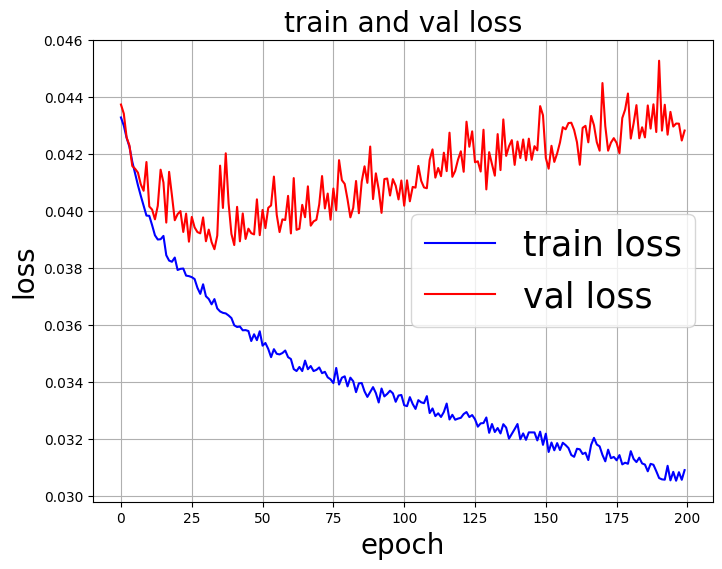

In [62]:
import matplotlib.pyplot as plt
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
ax.plot(range(num_epochs), test_loss_list, c='r', label='val loss')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('train and val loss', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()

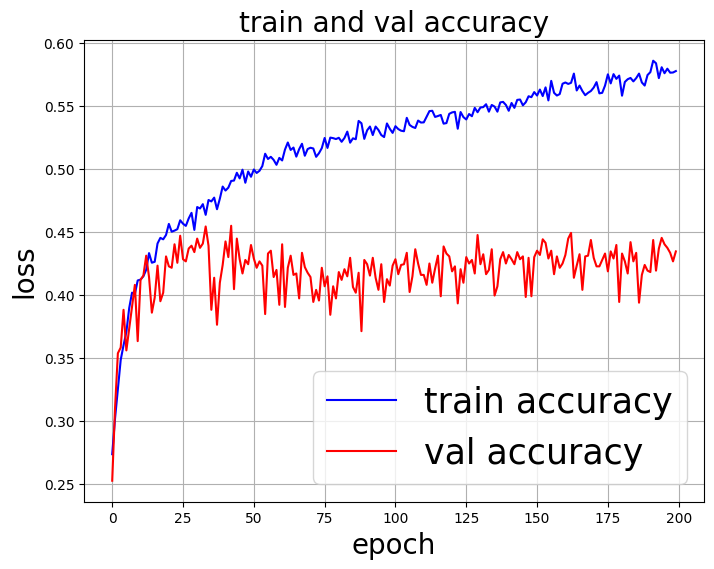

In [63]:
num_epochs = 200
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(range(num_epochs), train_acc_list, c='b', label='train accuracy')
ax.plot(range(num_epochs), test_acc_list, c='r', label='val accuracy')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('train and val accuracy', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()